In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import chi2_contingency, chi2
df = pd.read_csv("Clean data CS105 Winter'26 Mini-Project Survey (Responses).csv")

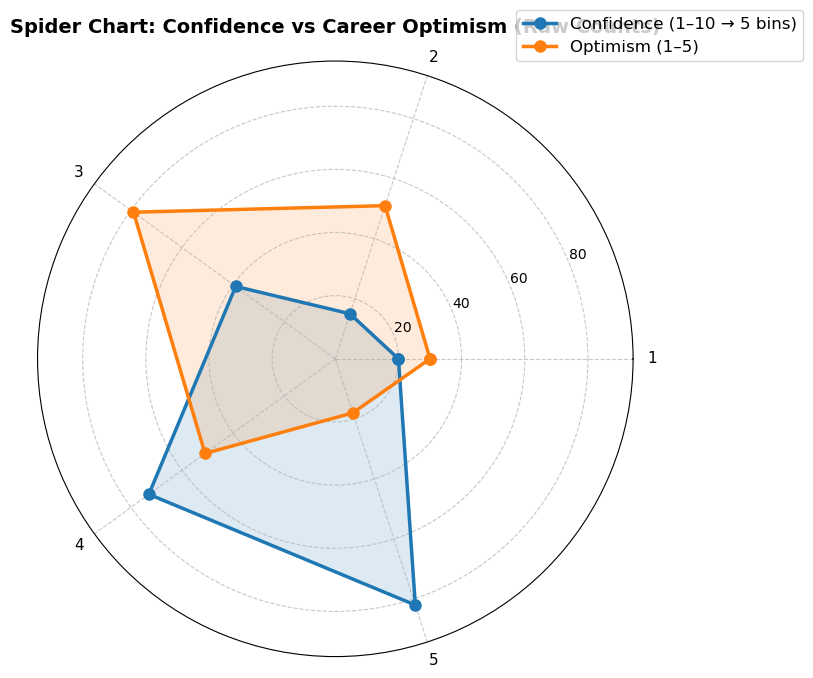

Confidence counts (bins 1..5): [20 15 39 73 82]
Optimism counts (1..5):        [30 51 79 51 18]


In [2]:
#Storing columns from df
conf_col = (
    "How confidently can you explain the following concepts to someone who hasn’t taken it? \n\n"
    "   FOR CS MAJORS/MINORS: Pointers, if/else statements, for/while loops\n"
    "   FOR DS MAJORS/MINORS: numpy, pandas, matplotlib, hypothesis testing"
)

opt_col = (
    "Please indicate how much you agree with the following statements regarding the current job market in your major.  "
    "(Each row should have one answer) [I feel optimistic about my career prospects in this field]"
)

#Dropping empty rows from confidence column
conf = df[conf_col].dropna()

#Binning the confidence levels so it fits on a 5 level scale
conf_bins = {
    1: [1, 2],
    2: [3, 4],
    3: [5, 6],
    4: [7, 8],
    5: [9, 10],
}

#Counting Responses
conf_counts = np.array([conf.isin(conf_bins[k]).sum() for k in range(1, 6)])

#Converting Text responses to numeric
opt_map = {
    "Strongly Disagree (1)": 1,
    "Disagree (2)": 2,
    "3 (3)": 3,
    "Agree (4)": 4,
    "Strongly Agree (5)": 5,
}

opt = df[opt_col].map(opt_map).dropna()

opt_counts = opt.value_counts().reindex([1, 2, 3, 4, 5], fill_value=0).values

metrics = ["1", "2", "3", "4", "5"]
num_metrics = len(metrics)

theta = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False)
theta = np.concatenate((theta, [theta[0]]))

datasets = [conf_counts, opt_counts]
labels = ["Confidence (1–10 → 5 bins)", "Optimism (1–5)"]
colors = ["#1f77b4", "#ff7f0e"]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, polar=True)

for i in range(2):
    values = np.concatenate((datasets[i], [datasets[i][0]]))  # close polygon

    ax.plot(
        theta,
        values,
        linewidth=2.5,
        linestyle="solid",
        label=labels[i],
        color=colors[i],
        marker="o",
        markersize=8,
    )
    ax.fill(theta, values, alpha=0.15, color=colors[i])

ax.set_xticks(theta[:-1])
ax.set_xticklabels(metrics, fontsize=11)

ax.set_ylim(0, max(conf_counts.max(), opt_counts.max()) * 1.15)
ax.grid(True, linestyle="--", alpha=0.7)

ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1), fontsize=12)
ax.set_title(
    "Spider Chart: Confidence vs Career Optimism (Raw Counts)",
    fontsize=14,
    fontweight="bold",
    pad=20,
)

plt.tight_layout()
plt.show()

print("Confidence counts (bins 1..5):", conf_counts)
print("Optimism counts (1..5):       ", opt_counts)


CONTINGENCY TABLE: Observed Frequencies
Optimism_level     1   2   3   4   5
Confidence_level                    
1                  3   2   5   4   5
2                  2   3   6   2   2
3                  4   6  21   7   1
4                  5  22  25  21   0
5                 16  18  22  16  10

Row Totals: [19 15 39 73 82] (Confidence Levels 1..5)
Column Totals: [30 51 79 50 18] (Optimism Levels 1..5)
Grand Total: 228 responses used


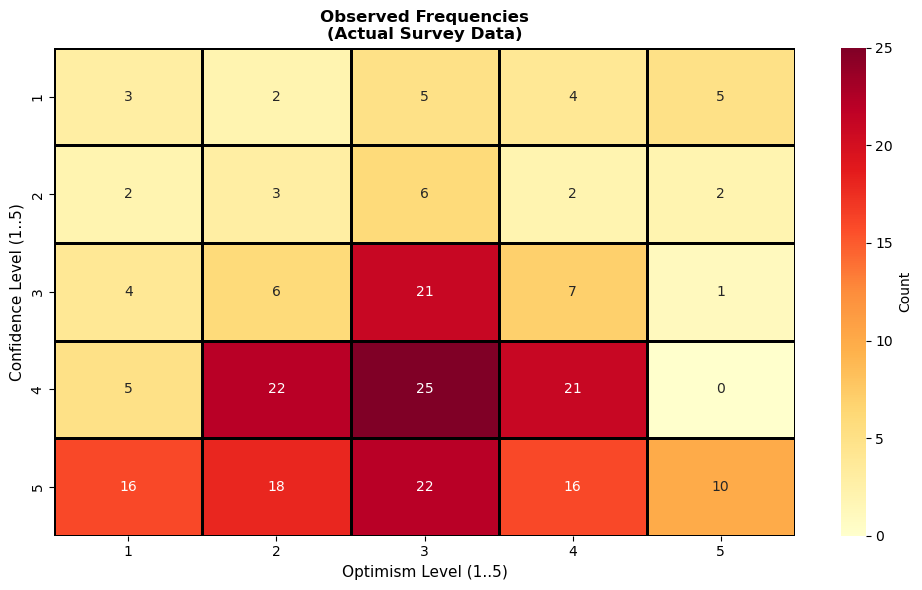

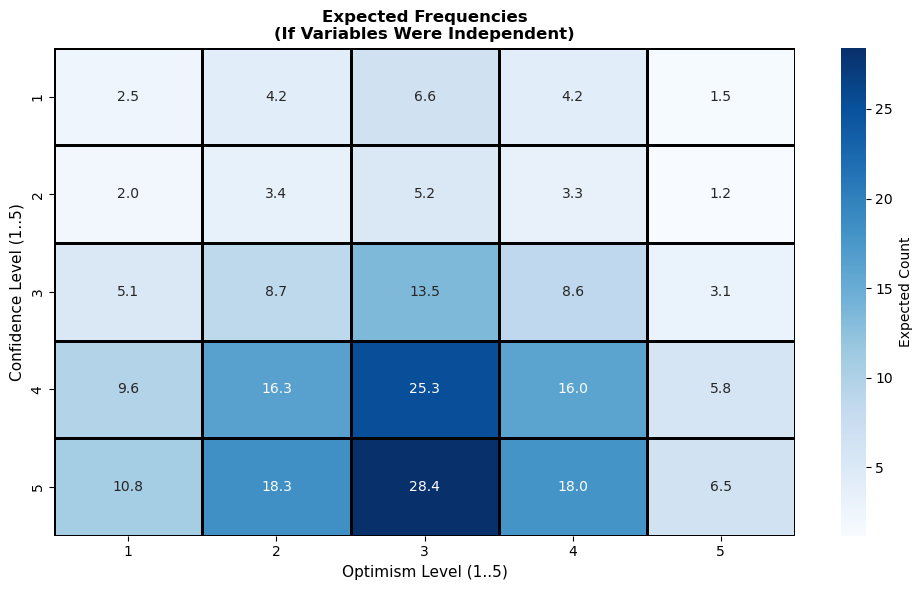


CHI-SQUARE TEST RESULTS
Chi-Square Statistic (χ²): 35.6178
P-value: 0.003268
Degrees of Freedom: 16

Significance Level: α = 0.05
Critical Value at α=0.05: 26.2962

INTERPRETATION
✓ REJECT the null hypothesis (independence)
  → The p-value (0.003268) is less than 0.05
  → The χ² statistic (35.6178) exceeds the critical value (26.2962)

  CONCLUSION: Confidence and optimism ARE associated!
  There is a statistically significant relationship between confidence level and career optimism.

ASSUMPTION CHECK (Expected Counts)
Minimum expected cell count: 1.184
Percent of expected cells < 5: 36.0%


In [3]:
conf_numeric = pd.to_numeric(df[conf_col], errors="coerce")

def conf_to_level(x):
    if pd.isna(x):
        return np.nan
    x = int(x)
    for level, vals in conf_bins.items():
        if x in vals:
            return level
    return np.nan

df["Confidence_level"] = conf_numeric.apply(conf_to_level)

df["Optimism_level"] = df[opt_col].map(opt_map)

analysis_df = df.dropna(subset=["Confidence_level", "Optimism_level"]).copy()
analysis_df["Confidence_level"] = analysis_df["Confidence_level"].astype(int)
analysis_df["Optimism_level"] = analysis_df["Optimism_level"].astype(int)

level_order = [1, 2, 3, 4, 5]

observed = pd.crosstab(
    analysis_df["Confidence_level"],
    analysis_df["Optimism_level"]
).reindex(index=level_order, columns=level_order, fill_value=0)

print("CONTINGENCY TABLE: Observed Frequencies")
print("=" * 50)
print(observed)
print("\nRow Totals:", observed.sum(axis=1).values, "(Confidence Levels 1..5)")
print("Column Totals:", observed.sum(axis=0).values, "(Optimism Levels 1..5)")
print("Grand Total:", observed.sum().sum(), "responses used")

chi_stat, p_value, degrees_freedom, expected_freq = chi2_contingency(observed)

plt.figure(figsize=(10, 6))
sns.heatmap(
    observed,
    annot=True,
    fmt='d',
    cmap='YlOrRd',
    cbar_kws={'label': 'Count'},
    linewidths=1,
    linecolor='black'
)
plt.title('Observed Frequencies\n(Actual Survey Data)', fontsize=12, fontweight='bold')
plt.xlabel('Optimism Level (1..5)', fontsize=11)
plt.ylabel('Confidence Level (1..5)', fontsize=11)
plt.tight_layout()
plt.show()

expected = pd.DataFrame(expected_freq, index=observed.index, columns=observed.columns)

plt.figure(figsize=(10, 6))
sns.heatmap(
    expected,
    annot=True,
    fmt='.1f',
    cmap='Blues',
    cbar_kws={'label': 'Expected Count'},
    linewidths=1,
    linecolor='black'
)
plt.title('Expected Frequencies\n(If Variables Were Independent)', fontsize=12, fontweight='bold')
plt.xlabel('Optimism Level (1..5)', fontsize=11)
plt.ylabel('Confidence Level (1..5)', fontsize=11)
plt.tight_layout()
plt.show()

print("\n" + "=" * 50)
print("CHI-SQUARE TEST RESULTS")
print("=" * 50)
print(f"Chi-Square Statistic (χ²): {chi_stat:.4f}")
print(f"P-value: {p_value:.6f}")
print(f"Degrees of Freedom: {degrees_freedom}")
print(f"\nSignificance Level: α = 0.05")

# Critical value at alpha=0.05
critical_value = chi2.ppf(0.95, degrees_freedom)
print(f"Critical Value at α=0.05: {critical_value:.4f}")

print("\n" + "=" * 50)
print("INTERPRETATION")
print("=" * 50)

if p_value < 0.05:
    print("✓ REJECT the null hypothesis (independence)")
    print(f"  → The p-value ({p_value:.6f}) is less than 0.05")
    print(f"  → The χ² statistic ({chi_stat:.4f}) exceeds the critical value ({critical_value:.4f})")
    print("\n  CONCLUSION: Confidence and optimism ARE associated!")
    print("  There is a statistically significant relationship between confidence level and career optimism.")
else:
    print("✗ FAIL TO REJECT the null hypothesis")
    print(f"  → The p-value ({p_value:.6f}) is greater than 0.05")
    print(f"  → The χ² statistic ({chi_stat:.4f}) is below the critical value ({critical_value:.4f})")
    print("\n  CONCLUSION: Cannot conclude that confidence and optimism are associated.")
    print("  The data is consistent with independence.")

min_expected = expected.values.min()
percent_under_5 = (expected.values < 5).mean() * 100

print("\n" + "=" * 50)
print("ASSUMPTION CHECK (Expected Counts)")
print("=" * 50)
print(f"Minimum expected cell count: {min_expected:.3f}")
print(f"Percent of expected cells < 5: {percent_under_5:.1f}%")


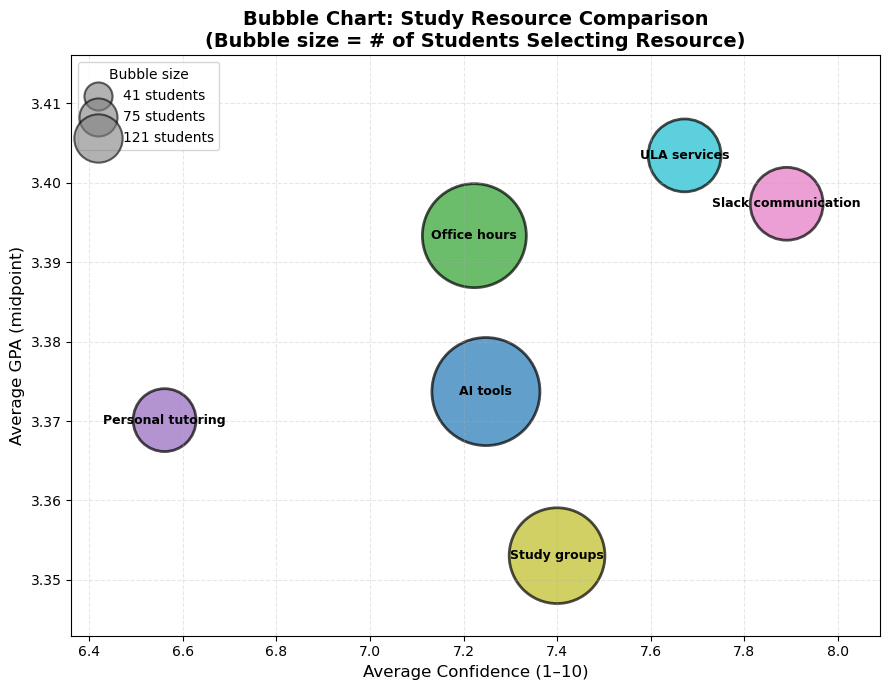

              Resource  mean_conf  mean_gpa  n_students
0             AI tools   7.247934  3.373719         121
1         Office hours   7.223214  3.393348         112
4         Study groups   7.400000  3.353053          95
3  Slack communication   7.890909  3.397364          55
5         ULA services   7.672727  3.403455          55
2    Personal tutoring   6.560976  3.370122          41


In [4]:
RES_COL = "Choose the resources that has been most helpful in your success in your favorite course. Choose all that apply.\n"
GPA_COL = "What is your current cumulative GPA?"
CONF_COL = "How confidently can you explain the following concepts to someone who hasn’t taken it? \n\n   FOR CS MAJORS/MINORS: Pointers, if/else statements, for/while loops\n   FOR DS MAJORS/MINORS: numpy, pandas, matplotlib, hypothesis testing"

df = df[[RES_COL, GPA_COL, CONF_COL]].copy()

#Cleaning data
df = df.dropna(subset=[CONF_COL])

df[GPA_COL] = df[GPA_COL].astype(str).str.strip()
df = df[df[GPA_COL] != "Prefer not to say"].copy()

#Converting ranges to midpoints
gpa_mid = {
    "< 1.33": 1.165,
    "1.67 – 2.0": 1.835,
    "2.0 – 2.33": 2.165,
    "2.33 – 2.67": 2.50,
    "2.67 – 3.0": 2.835,
    "3.0 – 3.33": 3.165,
    "3.33 – 3.67": 3.50,
    "3.67 – 4.0": 3.835,
}
df["GPA_mid"] = df[GPA_COL].map(gpa_mid)
df = df.dropna(subset=["GPA_mid"]).copy()

# Separates study resources into separate entries
df[RES_COL] = df[RES_COL].fillna("").astype(str).str.strip()
df["Resource"] = df[RES_COL].str.split(",")
df = df.explode("Resource")
df["Resource"] = df["Resource"].astype(str).str.strip()

# Remove "No resources"
df = df[~df["Resource"].isin(["", "N/A", "No resources"])].copy()

bubble = (
    df.groupby("Resource", as_index=False)
      .agg(
          mean_conf=(CONF_COL, "mean"),
          mean_gpa=("GPA_mid", "mean"),
          n_students=("Resource", "size")
      )
)

bubble = bubble[bubble["n_students"] >= 3].copy()

resources = bubble["Resource"].tolist()
confidence = bubble["mean_conf"].tolist()
gpa = bubble["mean_gpa"].tolist()
counts = bubble["n_students"].tolist()

palette = plt.cm.tab10(np.linspace(0, 1, max(3, len(resources))))
colors = [palette[i] for i in range(len(resources))]

plt.figure(figsize=(9, 7))

bubbles = plt.scatter(
    confidence, gpa,
    s=[c * 50 for c in counts],
    c=colors,
    alpha=0.7,
    edgecolors='black',
    linewidth=2
)

for i, name in enumerate(resources):
    plt.annotate(
        name,
        (confidence[i], gpa[i]),
        ha='center', va='center',
        fontweight='bold',
        fontsize=9
    )

plt.xlabel('Average Confidence (1–10)', fontsize=12)
plt.ylabel('Average GPA (midpoint)', fontsize=12)
plt.title('Bubble Chart: Study Resource Comparison\n(Bubble size = # of Students Selecting Resource)',
          fontsize=14, fontweight='bold')

plt.grid(True, alpha=0.3, linestyle='--')

x_range = max(confidence) - min(confidence)
y_range = max(gpa) - min(gpa)
plt.xlim(min(confidence) - x_range * 0.15, max(confidence) + x_range * 0.15)
plt.ylim(min(gpa) - y_range * 0.2, max(gpa) + y_range * 0.25)

legend_sizes = sorted(set([min(counts), int(np.median(counts)), max(counts)]))

legend_elements = [
    plt.scatter([], [], s=emp * 10, c='gray', alpha=0.6,
                edgecolors='black', linewidth=1.5,
                label=f'{emp} students')
    for emp in legend_sizes
]

plt.legend(handles=legend_elements, title="Bubble size", loc="upper left", frameon=True)

plt.tight_layout()
plt.show()

print(bubble.sort_values("n_students", ascending=False))


CONTINGENCY TABLE: Office Hours vs GPA Level
GPA_level     1   2    3    4    5
Office_Hours                      
False         4  24  112  106  121
True          2   7   30   32   41

Row Totals: [367 112]
Column Totals: [  6  31 142 138 162]
Grand Total: 479


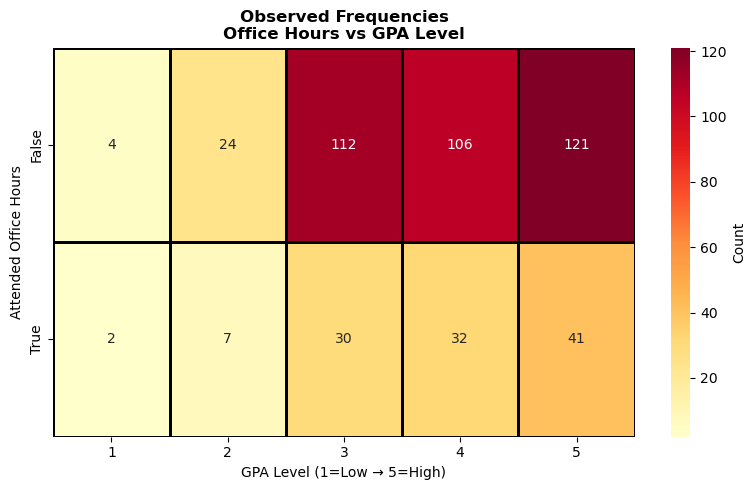

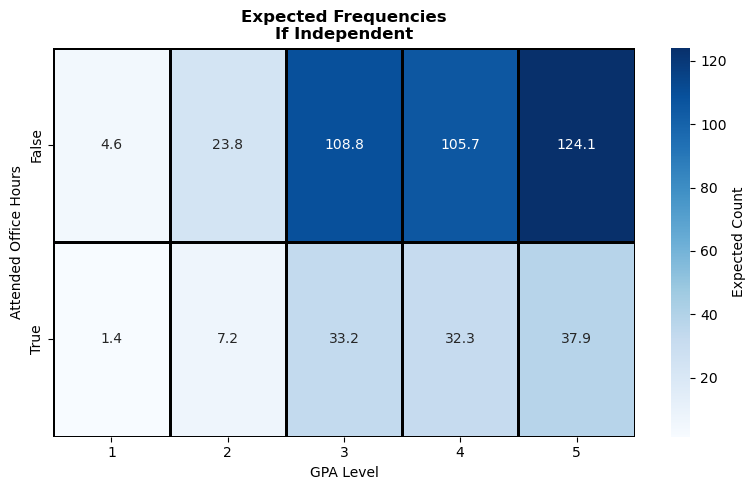


CHI-SQUARE TEST RESULTS
Chi-Square Statistic (χ²): 1.0845
P-value: 0.896728
Degrees of Freedom: 4
Critical Value at α=0.05: 9.4877

INTERPRETATION
✗ FAIL TO REJECT the null hypothesis
→ No statistically significant association found.

ASSUMPTION CHECK
Minimum expected cell count: 1.403
Percent of expected cells < 5: 20.0%


In [5]:
df["Office_Hours"] = df["Resource"] == "Office hours"

def gpa_to_level(x):
    if x < 2.0:
        return 1
    elif x < 2.7:
        return 2
    elif x < 3.3:
        return 3
    elif x < 3.7:
        return 4
    else:
        return 5

df["GPA_level"] = df["GPA_mid"].apply(gpa_to_level)

def conf_to_level(x):
    if x <= 2:
        return 1
    elif x <= 4:
        return 2
    elif x <= 6:
        return 3
    elif x <= 8:
        return 4
    else:
        return 5

df["Confidence_level"] = df[CONF_COL].apply(conf_to_level)

analysis_df = df.dropna(subset=["GPA_level", "Confidence_level"]).copy()

observed = pd.crosstab(
    analysis_df["Office_Hours"],
    analysis_df["GPA_level"]
)

print("CONTINGENCY TABLE: Office Hours vs GPA Level")
print("=" * 50)
print(observed)
print("\nRow Totals:", observed.sum(axis=1).values)
print("Column Totals:", observed.sum(axis=0).values)
print("Grand Total:", observed.sum().sum())

chi_stat, p_value, degrees_freedom, expected_freq = chi2_contingency(observed)

plt.figure(figsize=(8,5))
sns.heatmap(
    observed,
    annot=True,
    fmt='d',
    cmap='YlOrRd',
    cbar_kws={'label': 'Count'},
    linewidths=1,
    linecolor='black'
)
plt.title('Observed Frequencies\nOffice Hours vs GPA Level', fontweight='bold')
plt.xlabel('GPA Level (1=Low → 5=High)')
plt.ylabel('Attended Office Hours')
plt.tight_layout()
plt.show()

expected = pd.DataFrame(expected_freq, index=observed.index, columns=observed.columns)

plt.figure(figsize=(8,5))
sns.heatmap(
    expected,
    annot=True,
    fmt='.1f',
    cmap='Blues',
    cbar_kws={'label': 'Expected Count'},
    linewidths=1,
    linecolor='black'
)
plt.title('Expected Frequencies\nIf Independent', fontweight='bold')
plt.xlabel('GPA Level')
plt.ylabel('Attended Office Hours')
plt.tight_layout()
plt.show()

print("\n" + "=" * 50)
print("CHI-SQUARE TEST RESULTS")
print("=" * 50)
print(f"Chi-Square Statistic (χ²): {chi_stat:.4f}")
print(f"P-value: {p_value:.6f}")
print(f"Degrees of Freedom: {degrees_freedom}")

critical_value = chi2.ppf(0.95, degrees_freedom)
print(f"Critical Value at α=0.05: {critical_value:.4f}")

print("\nINTERPRETATION")
print("=" * 50)

if p_value < 0.05:
    print("✓ REJECT the null hypothesis (independence)")
    print("→ Office Hours attendance IS statistically associated with GPA level.")
else:
    print("✗ FAIL TO REJECT the null hypothesis")
    print("→ No statistically significant association found.")

min_expected = expected.values.min()
percent_under_5 = (expected.values < 5).mean() * 100

print("\nASSUMPTION CHECK")
print("=" * 50)
print(f"Minimum expected cell count: {min_expected:.3f}")
print(f"Percent of expected cells < 5: {percent_under_5:.1f}%")


CONTINGENCY TABLE: Office Hours vs Confidence Level
Confidence_level   1   2   3    4    5
Office_Hours                          
False             25  21  60  126  135
True               8   7  21   36   40

Row Totals: [367 112]
Column Totals: [ 33  28  81 162 175]
Grand Total: 479


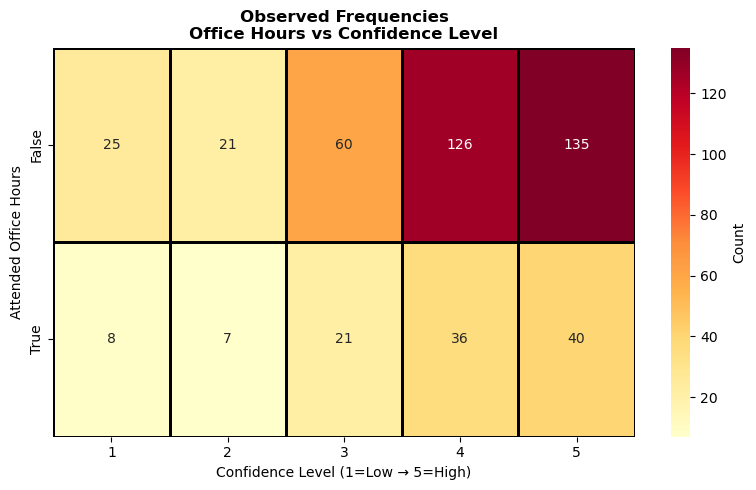

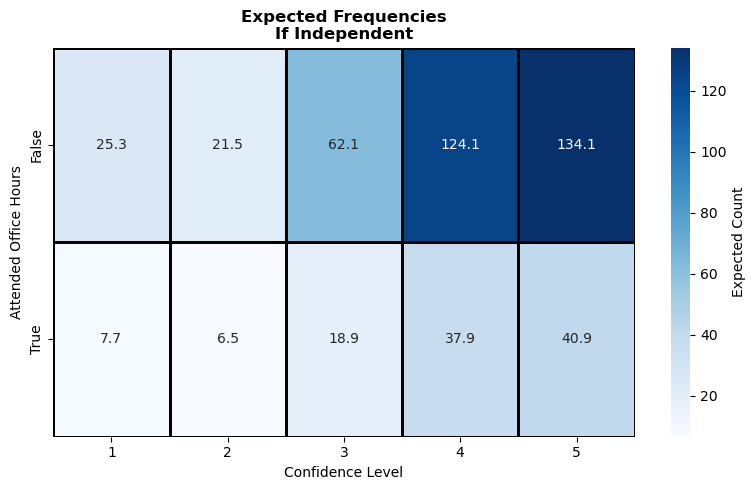


CHI-SQUARE TEST RESULTS
Chi-Square Statistic (χ²): 0.4957
P-value: 0.973918
Degrees of Freedom: 4
Critical Value at α=0.05: 9.4877

INTERPRETATION
✗ FAIL TO REJECT the null hypothesis
→ No statistically significant association found.

ASSUMPTION CHECK
Minimum expected cell count: 6.547
Percent of expected cells < 5: 0.0%


In [6]:
df["Office_Hours"] = df["Resource"] == "Office hours"

def conf_to_level(x):
    if x <= 2:
        return 1
    elif x <= 4:
        return 2
    elif x <= 6:
        return 3
    elif x <= 8:
        return 4
    else:
        return 5

df["Confidence_level"] = df[CONF_COL].apply(conf_to_level)

analysis_df = df.dropna(subset=["Confidence_level"]).copy()
analysis_df["Confidence_level"] = analysis_df["Confidence_level"].astype(int)

level_order = [1, 2, 3, 4, 5]

observed = pd.crosstab(
    analysis_df["Office_Hours"],
    analysis_df["Confidence_level"]
).reindex(columns=level_order, fill_value=0)

print("CONTINGENCY TABLE: Office Hours vs Confidence Level")
print("=" * 50)
print(observed)
print("\nRow Totals:", observed.sum(axis=1).values)
print("Column Totals:", observed.sum(axis=0).values)
print("Grand Total:", observed.sum().sum())

chi_stat, p_value, degrees_freedom, expected_freq = chi2_contingency(observed)

plt.figure(figsize=(8,5))
sns.heatmap(
    observed,
    annot=True,
    fmt='d',
    cmap='YlOrRd',
    cbar_kws={'label': 'Count'},
    linewidths=1,
    linecolor='black'
)
plt.title('Observed Frequencies\nOffice Hours vs Confidence Level', fontweight='bold')
plt.xlabel('Confidence Level (1=Low → 5=High)')
plt.ylabel('Attended Office Hours')
plt.tight_layout()
plt.show()

expected = pd.DataFrame(expected_freq, index=observed.index, columns=observed.columns)

plt.figure(figsize=(8,5))
sns.heatmap(
    expected,
    annot=True,
    fmt='.1f',
    cmap='Blues',
    cbar_kws={'label': 'Expected Count'},
    linewidths=1,
    linecolor='black'
)
plt.title('Expected Frequencies\nIf Independent', fontweight='bold')
plt.xlabel('Confidence Level')
plt.ylabel('Attended Office Hours')
plt.tight_layout()
plt.show()

print("\n" + "=" * 50)
print("CHI-SQUARE TEST RESULTS")
print("=" * 50)
print(f"Chi-Square Statistic (χ²): {chi_stat:.4f}")
print(f"P-value: {p_value:.6f}")
print(f"Degrees of Freedom: {degrees_freedom}")

critical_value = chi2.ppf(0.95, degrees_freedom)
print(f"Critical Value at α=0.05: {critical_value:.4f}")

print("\nINTERPRETATION")
print("=" * 50)

if p_value < 0.05:
    print("✓ REJECT the null hypothesis (independence)")
    print("→ Office Hours attendance IS statistically associated with Confidence Level.")
else:
    print("✗ FAIL TO REJECT the null hypothesis")
    print("→ No statistically significant association found.")

min_expected = expected.values.min()
percent_under_5 = (expected.values < 5).mean() * 100

print("\nASSUMPTION CHECK")
print("=" * 50)
print(f"Minimum expected cell count: {min_expected:.3f}")
print(f"Percent of expected cells < 5: {percent_under_5:.1f}%")
